In [1]:
import pandas as pd
import numpy as np
import glob
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from tkinter import filedialog
import tkinter as tk

root = tk.Tk()

default_times = times = list(range(0, 31)) + list(range(35, 95, 5))
# folder_path = filedialog.askdirectory(title='Select Data Folder')
folder_1 = r'C:/Users/jgage/OneDrive/Documents/Biosensor Files/FRET/MMP9/04062021 MMP9 Bulk/5'
folder_2 = r'C:/Users/jgage/OneDrive/Documents/Biosensor Files/FRET/MMP9/04062021 MMP9 Bulk/7 plus a half'
folder_3 = r'C:/Users/jgage/OneDrive/Documents/Biosensor Files/FRET/MMP9/04062021 MMP9 Bulk/10'
folder_4 = r'C:/Users/jgage/OneDrive/Documents/Biosensor Files/FRET/MMP9/03152021 MMP9 Bulk/15'
folder_5 = r'C:/Users/jgage/OneDrive/Documents/Biosensor Files/FRET/MMP9/03152021 MMP9 Bulk/20'
folder_6 = r'C:/Users/jgage/OneDrive/Documents/Biosensor Files/FRET/MMP9/03152021 MMP9 Bulk/30'
folder_7 = r'C:/Users/jgage/OneDrive/Documents/Biosensor Files/FRET/MMP9/03152021 MMP9 Bulk/50'
folder_list = [folder_1, folder_2, folder_3, folder_4, folder_5, folder_6, folder_7]

In [17]:
# EP1 import functions
def episodic_to_dataframe(file):
    '''
    Takes .EP1x file, returns dataframe indexed by wavelength and 'epx'
    where x is the episode number

    pd.read_csv needs to know how many columns there will be before importing
    or else it will assume the first row contains column names, not data
    '''
    row = pd.read_csv(file, delim_whitespace=True, nrows=1)
    num_episodes = len(row.columns) - 1
    column_names = ['wavelength']
    for column in range(num_episodes):
        column_names.append('ep' + str(column + 1))
    # Now it will actually be imported
    raw = pd.read_csv(file, delim_whitespace=True, index_col=0, names=column_names)
    # Columns are now indexed with their episode number.
    # raw.loc['wavelength'] = raw.loc['wavelength'].sub(7.5)
    return raw

# 15 SECOND OFFSET 
def get_times(params, episodes):
    '''
    Returns a list of times, marking the start of each collection period
    Times are strictly in seconds
    '''
    collection_period = params['scans_avg'] * (int(params['int_time']) / 1000)
    delay = ((int(params['min_delay']) * 60) + (int(params['ms_delay']) / 1000))
    times = []
    for ep in range(episodes):
        times.append(
            int(ep * (collection_period + delay) + 15)
        )
    return times

def convert_times(list):
    '''
    Takes list of times in seconds
    Returns list of times in more readable H:M:S format
    '''
    time_codes = []
    for i in list:
        time_codes.append(time.strftime("%H:%M:%S", time.gmtime(i)))
    return time_codes

In [3]:
# Linear Regression
def Least_sq(x, y):
    reg_x = x.values.reshape(-1,1)
    reg_y = y.values.reshape(-1,1)
    reg = LinearRegression().fit(reg_x, reg_y)
    return [reg, reg_x, reg_y]

# The set of associated metrics to report, check Skoog textbook for definitions
def get_Sumsq(reg_x):
    x_bar = sum(reg_x) / len(reg_x)
    xi_minus_xbar_sq = []
    for i in range(len(reg_x[:,0])):
        xi_minus_xbar_sq.append((reg_x[i, 0] -  x_bar)**2)
    return sum(xi_minus_xbar_sq)

def get_Sxy(reg_x, reg_y):
    x_bar = sum(reg_x) / len(reg_x)
    xi_minus_xbar = []
    for i in range(len(reg_x[:,0])):
        xi_minus_xbar.append(reg_x[i, 0] -  x_bar)
    
    y_bar = sum(reg_y) / len(reg_y)
    yi_minus_ybar = []
    for i in range(len(reg_y[:,0])):
        yi_minus_ybar.append(reg_y[i, 0] -  y_bar)
        
    products = []
    for i in range(len(xi_minus_xbar)):
        products.append(xi_minus_xbar[i] * yi_minus_ybar[i])
    return sum(products)

def get_sy(reg_x, reg_y):
    n = len(reg_x[:,0])
    reg = LinearRegression().fit(reg_x, reg_y)
    return (((get_Sumsq(reg_y) - ((float(reg.coef_) ** 2) * get_Sumsq(reg_x))) / (n-2))) ** (1/2)

def get_sm(reg_x, reg_y):
    n = len(reg_x[:,0])
    num = (get_sy(reg_x, reg_y) ** 2) * n
    denom = (n * sum(reg_x ** 2)) - sum(reg_x)**2
    return (num / denom) ** (1/2)

def get_sb(reg_x, reg_y):
    n = len(reg_x[:,0])
    num = (get_sy(reg_x, reg_y) ** 2) * sum(reg_x ** 2)
    denom = (n * sum(reg_x ** 2)) - sum(reg_x)**2
    return (num / denom) ** (1/2)

def get_Ext_sx(reg_x, reg_y, unknown_mean, replicants=1):
    n = len(reg_x[:,0])
    reg = LinearRegression().fit(reg_x, reg_y)
    y_bar = sum(reg_y) / len(reg_y)
    num = (unknown_mean - y_bar) ** 2
    denom = (float(reg.coef_)**2) * get_Sumsq(reg_x)
    return (get_sy(reg_x, reg_y) / abs(float(reg.coef_))) * (((1/n) + (1/replicants) + (num/denom)) ** (1/2))

def get_SA_sx(reg_x, reg_y):
    n = len(reg_x[:,0])
    reg = LinearRegression().fit(reg_x, reg_y)
    y_bar = sum(reg_y) / len(reg_y)
    num = y_bar ** 2
    denom = (float(reg.coef_)**2) * get_Sumsq(reg_x)
    return (get_sy(reg_x, reg_y) / abs(float(reg.coef_))) * (((1/n) + (num/denom)) ** (1/2))

In [18]:
# Import several folders of episodic data, with the assumption that the data are all the same shape (see episodic to dataframe fucntion)
# essentially, all columns should be episode spectra
# The data are imported into the dfl_list object (a list of DataFrame lists corresponding to each folder (concentration)
# Each dfl in dfl_list has [params, raw, signal]

# Get Params
params = pd.Series({'int_time': 3000,
                   'scans_avg': 10,
                   'min_delay': 0,
                   'ms_delay': 0
                  })

dfl5, dfl7_5, dfl10, dfl15, dfl20, dfl30, dfl50 = [], [], [], [], [], [], []
dfl_list = [dfl5, dfl7_5, dfl10, dfl15, dfl20, dfl30, dfl50]
for i in range(len(folder_list)):
    for filename in os.listdir(folder_list[i]):
        if filename.lower().endswith(".ep1x"):
            dfl_list[i].append([(params.append(pd.Series({'filename': filename}))),
                                               episodic_to_dataframe(folder_list[i] + '/' + filename)])

def add_times(df):
    '''
    Puts times on top of dataframe
    '''
    num_episodes = len(df.columns)
    times_in_seconds = get_times(params, num_episodes)
    time_codes = convert_times(times_in_seconds)

# Create a DataFrame that maps episodes to times. Just move this into import function for generality
    time_dict = {}
    name_dict = {}
    for i in range(num_episodes):
        time_dict[i] = [times_in_seconds[i], time_codes[i]]
        name_dict[i] = 'ep' + (str(i + 1))
    time_df = pd.DataFrame(data=time_dict,
                           index=['time (s)', 'H/M/S'],)
    time_df.rename(name_dict, inplace=True, axis=1)
    df = time_df.append(df, ignore_index=False)
    return df
    
# Put times at the top of each df in dfl_list
for i in range(len(dfl_list)):
    for j in range(len(dfl_list[i])):
        dfl_list[i][j][1] = add_times(dfl_list[i][j][1])

# Extract the signal
for i in range(len(dfl_list)):
    for j in range(len(dfl_list[i])):
        signal = dfl_list[i][j][1].iloc[569:578,:].mean(axis=0)
        if j == 0:
            dfl_list[i].append(signal.rename(('signal' + str(j + 1)), axis = 1).to_frame())
        else:
            #dfl_list[i][-1]['signal' + str(j + 1)] = signal.rename(('signal' + str(j + 1)), axis = 1).to_frame()
            dfl_list[i][-1] = pd.concat([dfl_list[i][-1], signal.rename(('signal' + str(j + 1)), axis = 1).to_frame()], axis=1, join='outer')
            
# Again assuming times are the same for each trial
# for i in range(len(dfl_list[:])):
#     dfl_list[i][-1]['time (s)'] = dfl_list[i][-2][1].loc['time (s)', :]


# ^^That assumption failed here...
for i in range(len(dfl_list[:])):
    dfl_list[i][-1]['time (s)'] = dfl_list[i][-2][1].loc['time (s)', :]
    #print('i:'+str(i), dfl_list[i][-1]['time (s)'])
    
# Make regl objects for each trial
# for i in range(len(dfl_list)):
#     for j in range(len(dfl_list[i][-1].columns)):
#         if dfl_list[i][-1].columns[j] != 'time (s)':
#             regl = Least_sq(dfl_list[i][-1]['time (s)'], dfl_list[i][-1].iloc[:,j])
#             dfl_list[i][j][0] = dfl_list[i][j][0].append(pd.Series([regl, regl[0], regl[1], regl[2]],
#                                                                    index=['regl', 'reg', 'reg_x', 'reg_y']))

def export_files(dfl_list, params):
    '''
    Takes the dfl_list generated from the data folder
    Saves each summary df and params to separate sheets in a single .xlsx file in the save location
    '''
    # save_path = filedialog.asksaveasfile(title='Select Save Location', filetypes=[('Microsoft Excel Worksheet', '.xlsx')])
    save_path = r'C:/Users/jgage/OneDrive/Documents/Biosensor Files/FRET/MMP9/04062021 MMP9 Bulk'
    #save_name = save_path.name
    save_name = 'Bulk Export.xlsx'
    if save_name[-5:] != '.xlsx':
        save_name = str(save_name + '.xlsx')
    with pd.ExcelWriter(save_name) as writer:
        for i in range(len(dfl_list)):
            dfl_list[i][-1].to_excel(writer,sheet_name='Conc' + str(i))
        params.to_excel(writer, sheet_name='params')
        
# export_files(dfl_list, params)

Index(['time (s)',    'H/M/S',      183.2,      183.6,      184.0,      184.4,
            184.8,      185.2,      185.6,      186.0,
       ...
            848.2,      848.5,      848.7,      849.0,      849.2,      849.5,
            849.7,      849.9,      850.2,      850.4],
      dtype='object', length=2053)


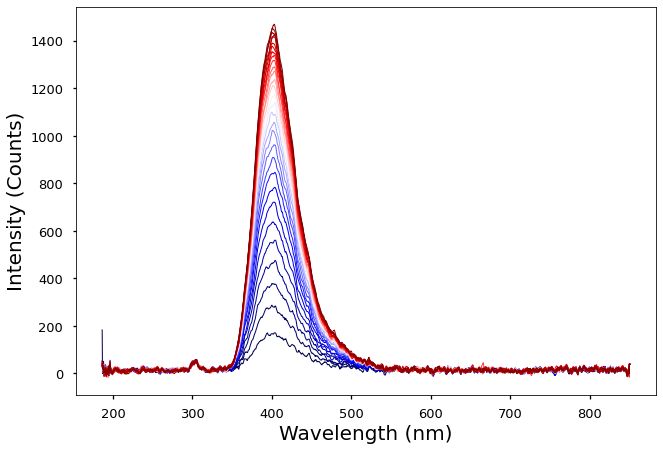

In [35]:
# Make plots
def plot_reg_from_regl(regl, vol=False, name='Unnamed Figure', title=''):
    reg, reg_x, reg_y = regl[0], regl[1], regl[2]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(reg_x, reg_y, c='k', zorder=1)
    ax.plot(reg_x, reg.predict(reg_x), color='r', zorder=0.8)


def plot_run_spectra(data_df):
    data_df.drop(['time (s)', 'H/M/S'], axis=0, inplace=True)
    fig = plt.figure()
    ax = fig.add_subplot
    for spectrum in data_df.iteritems():
        ax.plot(data_df.index, data_df[spectrum])
    return fig


def plot_spectra(df, text='', save_name=''):
    # Plot conc, trial, 1=raw spectra. Omit first 10 wavelengths
    plt.style.use('seaborn-talk')
    fig, ax = plt.subplots()
    ax.set_ylabel('Intensity (Counts)', fontsize=20)
    ax.set_xlabel('Wavelength (nm)', fontsize=20)
    df.iloc[10:,:].plot(use_index=True, colormap='seismic', legend=False, ax=ax, linewidth=1)
    ax.text(.95, 0.85, 
            text, font='arial', 
            fontsize=16, horizontalalignment='right', transform=ax.transAxes)
    if save_name != '':
        fig.savefig('figs/'+str(save_name), dpi=600, pad_inches=0)
    return fig

def plot_run(df, text='', save_name=''):
    # Plot conc, trials (signal df) as signal vs. time
    plt.style.use('seaborn-talk')
    fig, ax = plt.subplots()
    for column in df.iloc[:,:-1].columns.to_list():
        ax.scatter(x=df['time (s)'], y=df[column], label=column)
        ax.legend()
        ax.text(.95, 0.05, 
            text, font='arial', 
            fontsize=14, verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
    ax.set_ylabel('Intensity (Counts)', fontsize=20)
    ax.set_xlabel('Time (s)', fontsize=20)
    if save_name != '':
        fig.savefig('figs/'+str(save_name), dpi=600, pad_inches=0)
    return fig

plot_spectra(dfl15[0][1])
print(dfl30[1][1].index)

In [27]:
# means, sds = [], []
# for trial in range(4):
#     means.append(dfl30[trial][1].iloc[301:308,:].mean(axis=0).mean(axis=0))
#     sds.append(dfl30[trial][1].iloc[301:308,:].mean(axis=0).std(axis=0))


print(list(dfl30[1][1].iloc[301:308].index))

[301.3, 301.7, 302.1, 302.5, 302.9, 303.2, 303.6]
